In [132]:
import math
from collections import defaultdict
import matplotlib.pyplot as plt

import networkx as nx

from tweepy import API
from tweepy import OAuthHandler
from tweepy import Cursor

%matplotlib inline

# Authentication

In [133]:
consumer_key    = 'bqvwgyk8I949tn3lJiHlgGfqk'
consumer_secret = 'yif4sIXhLHoGCQmBiu8AUoqiY2WcgTaHO44QQnfbQVuLuf40SG' 
access_token    = '265463749-0dR3F7mUcuU2PM0uTxR4sQWaODHFRYzDEauJH27z'
access_secret   = 'lWBFfYdqxu9tK5s626hSDpx1tvkUCOpPW1Cvk1tLlyyHq'

def get_twitter_auth():
    """Setup Twitter Authentication.
    
    Return: tweepy.OAuthHandler object
    """
    auth = OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_token, access_secret)
    return auth
    
def get_twitter_client():
    """Setup Twitter API Client.
    
    Return: tweepy.API object
    """
    auth = get_twitter_auth()
    client = API(auth)
    return client

from config import *
api = get_twitter_client()

# Functions

In [134]:
def makedir(screen_name):
    dirname = 'users/{}'.format(screen_name)

    try:
        os.makedirs(dirname, mode=0o755, exist_ok=True)
    except OSError:
        print('Directory {} already exists.'.format(dirname))
    except Exception as e:
        print('Error while creating directory {}'.format(dirname))
        print(e)
        sys.exit(1)

def paginate(items, n):
    """Generate n-sized chunks for items."""
    for i in range(0, len(items), n):
        yield items[i:i+n]

def get_user_ff(client, screen_name, graph_limit=20000, MAX_FRIENDS=2000):
    """Get friends and followers for a given user.
    
    Return: users/{}/followers.jsonl and
            users/{}/friends.jsonl
    """
    # parameters
    #client = twitter_client.get_twitter_client()
    max_pages = math.ceil(MAX_FRIENDS / 5000)
    
    # Make dir structure
    makedir(screen_name)
    
    graph_counter = 0
    # get followers for a given user
    fname = 'users/{}/followers.jsonl'.format(screen_name)
    with open(fname, 'w') as f:
        for followers in Cursor(client.followers_ids, screen_name=screen_name).pages(max_pages):
            for chunk in paginate(followers, 100):
                if graph_counter < graph_limit:
                    users = client.lookup_users(user_ids=chunk)
                    for user in users:
                        f.write(json.dumps(user._json)+'\n')
                    if len(followers) == 5000:
                        print("More results available. Sleeping for 60 seconds to avoid rate limit")
                        time.sleep(60)
                    graph_counter += 100
                elif graph_counter < graph_limit:
                    break
    
    graph_counter = 0
    # get friends for a given user
    fname = 'users/{}/friends.jsonl'.format(screen_name)
    with open(fname, 'w') as f:
        for friends in Cursor(client.friends_ids, screen_name=screen_name).pages(max_pages):
            for chunk in paginate(friends, 100):
                if graph_counter < graph_limit:
                    if graph_counter < graph_limit:
                        users = client.lookup_users(user_ids=chunk)
                        for user in users:
                            f.write(json.dumps(user._json)+'\n')
                        graph_counter += (1*100)
                    if len(friends) == 5000:
                        print("More results available. Sleeping for 60 seconds to avoid rate limit")
                        time.sleep(60)
                    graph_counter += 100
                elif graph_counter < graph_limit:
                    break

# Process Data

## Input Parameter

In [135]:
myself_screen_name = 'X1alejandro3x'

## Center Node

In [144]:
# Center node
myself_user = api.lookup_users(screen_names=[myself_screen_name])
myself = myself_user[0]

# get follower
get_user_ff(api, myself_screen_name, graph_limit=200)

# Build Graph
followers_file = 'users/{}/followers.jsonl'.format(myself_screen_name)
friends_file = 'users/{}/friends.jsonl'.format(myself_screen_name)
with open(followers_file) as f1, open(friends_file) as f2:     
    hfollowers = defaultdict(lambda: 0)
    
    graph = nx.MultiDiGraph()
    graph.add_node(myself.screen_name, followers=int(myself.followers_count))
    
    # Add followers to network
    for line in f1:
        profile = json.loads(line)
        if profile['screen_name'] not in graph:
            graph.add_node(profile['screen_name'], followers=int(profile['followers_count']))
            graph.add_edge(myself.screen_name, profile['screen_name'], followers=int(profile['followers_count']))
            hfollowers[profile['screen_name']] = int(profile['followers_count'])
            
    # Add friends to network
    for line in f2:
        profile = json.loads(line)
        if profile['screen_name'] not in graph:
            graph.add_node(profile['screen_name'],followers=int(profile['followers_count']) )
            graph.add_edge(profile['screen_name'], myself.screen_name, followers=int(profile['followers_count']))
            hfollowers[profile['screen_name']] = int(profile['followers_count'])

## Adding Degrees of Separation

In [145]:
with open(followers_file) as f:
    # Limit the size of the network
    node_counter, node_limit = 1, 3
    
    for line in f:
        if node_counter<node_limit:
            node_counter += 1
            profile = json.loads(line)
            
            # get followers and friends for given user
            get_user_ff(api, profile['screen_name'], graph_limit=200)

            # Add to network
            followers_file = 'users/{}/followers.jsonl'.format(profile['screen_name'])
            friends_file = 'users/{}/friends.jsonl'.format(profile['screen_name'])
            with open(followers_file) as f1, open(friends_file) as f2:
                # Add followers of given follower to network
                for line in f1:
                    profile = json.loads(line)
                    if profile['screen_name'] not in graph:
                        graph.add_node(profile['screen_name'], followers=int(profile['followers_count']))
                        graph.add_edge(myself.screen_name, profile['screen_name'], 
                                       followers=int(profile['followers_count']))
                        hfollowers[profile['screen_name']] = int(profile['followers_count'])

                # Add friends of given follower to network
                for line in f2:
                    profile = json.loads(line)
                    if profile['screen_name'] not in graph:
                        graph.add_node(profile['screen_name'], followers=int(profile['followers_count']))
                        graph.add_edge(profile['screen_name'], myself.screen_name, 
                                       followers=int(profile['followers_count']))
                        hfollowers[profile['screen_name']] = int(profile['followers_count'])

More results available. Sleeping for 60 seconds to avoid rate limit
More results available. Sleeping for 60 seconds to avoid rate limit
More results available. Sleeping for 60 seconds to avoid rate limit
More results available. Sleeping for 60 seconds to avoid rate limit
More results available. Sleeping for 60 seconds to avoid rate limit
More results available. Sleeping for 60 seconds to avoid rate limit


In [146]:
print(nx.info(graph))

Name: 
Type: MultiDiGraph
Number of nodes: 863
Number of edges: 862
Average in degree:   0.9988
Average out degree:   0.9988


# Visualization

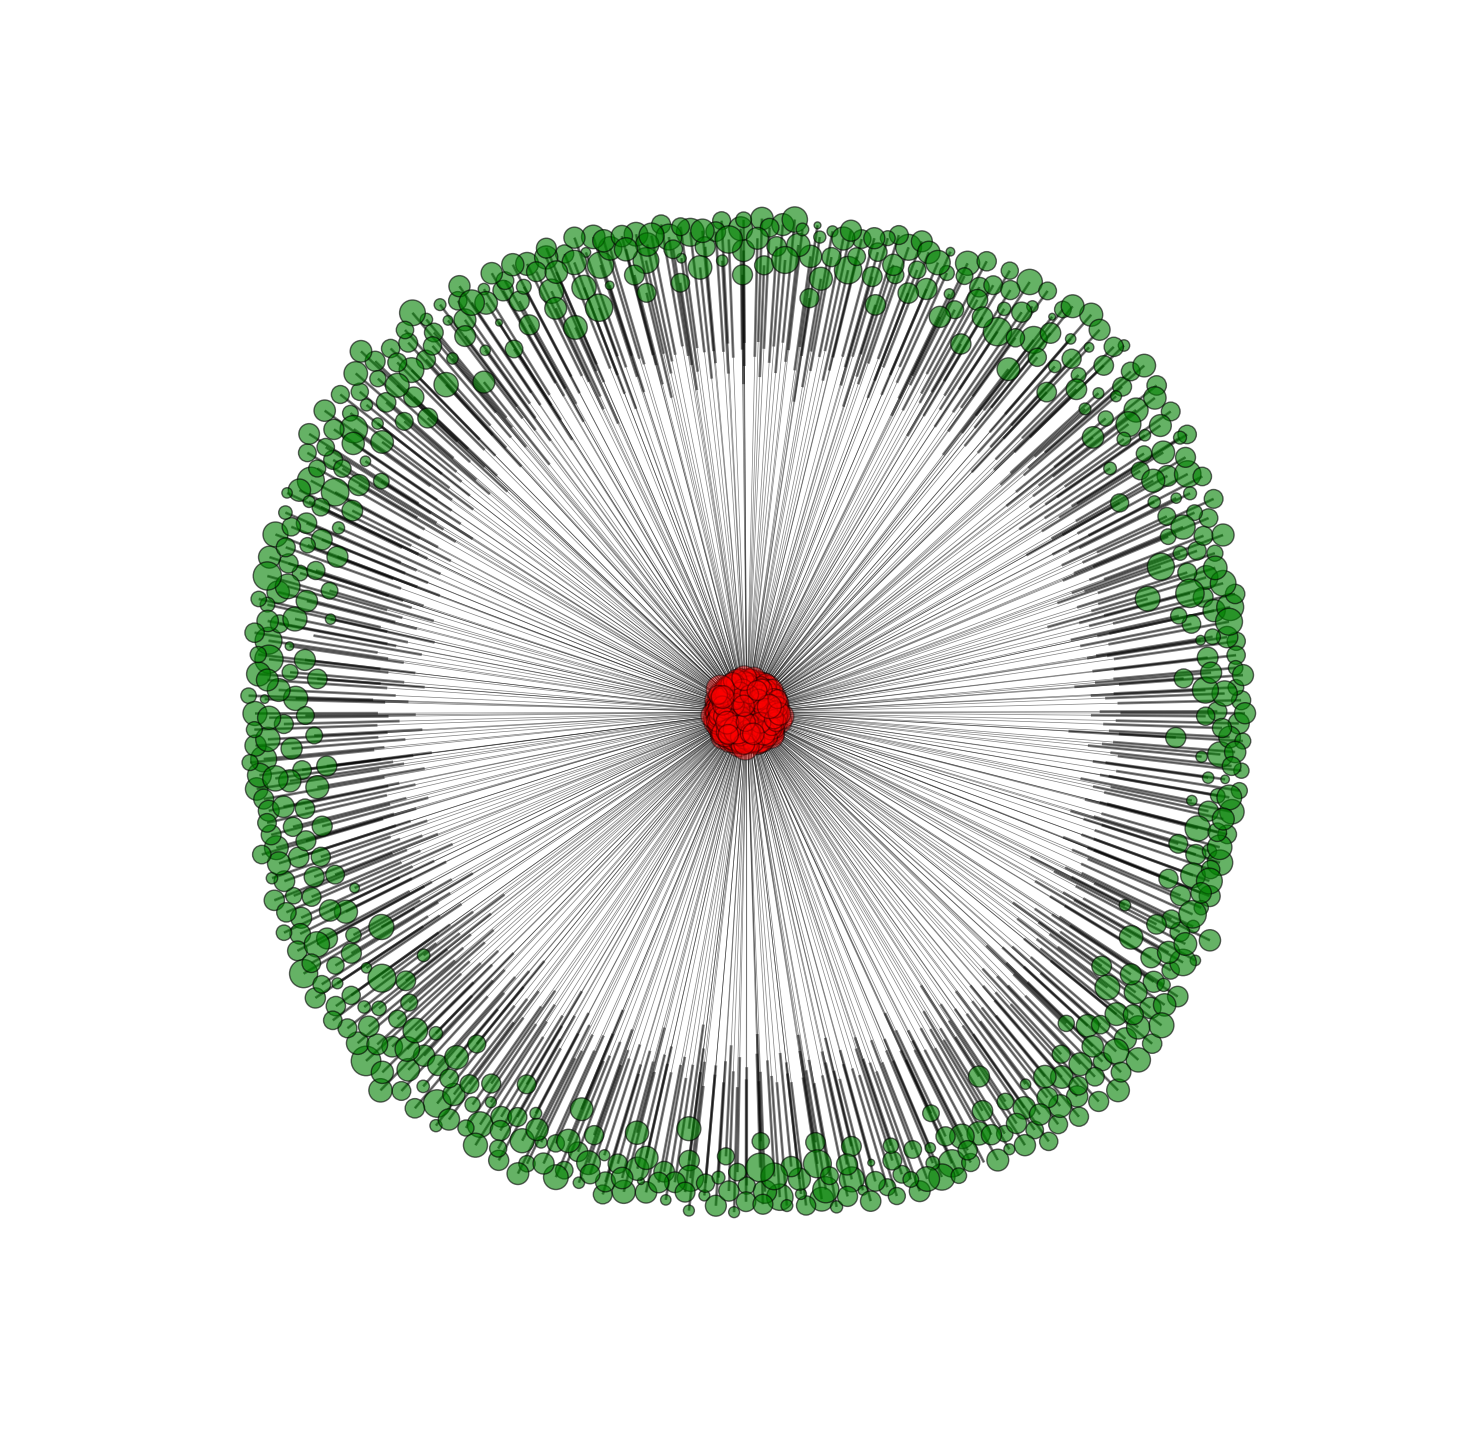

In [147]:
# centre around the SEED node and set radius of graph
SEED = myself.screen_name
g = nx.DiGraph(nx.ego_graph(graph, SEED, radius=4))


nodesets = defaultdict(list)
opts = ['follower', 'friend']
nodesets[opts[0]] = [n for n in graph.nodes_iter() if graph.has_edge(myself.screen_name, n)]
nodesets[opts[1]] = [n for n in graph.nodes_iter() if graph.has_edge(n, myself.screen_name)]

colours = ['red','green']
colourmap = {}

plt.figure(figsize=(18,18))
plt.axis('off')

pos = nx.spring_layout(graph) # compute layout

# draw nodes
i = 0
alphas = {'follower': 0.6, 'friend': 0.4}
for k in nodesets.keys():
    ns = [ math.log10(hfollowers[n]+1) * 80 for n in nodesets[k] ]
    nx.draw_networkx_nodes(graph, pos, nodelist=nodesets[k], node_size=ns, node_color=colours[i], alpha=alphas[k])
    colourmap[k] = colours[i]
    i += 1

# Edges
nx.draw_networkx_edges(graph, pos, width=0.5, alpha=0.5)

In [141]:
help(nx.draw_networkx_nodes)

Help on function draw_networkx_nodes in module networkx.drawing.nx_pylab:

draw_networkx_nodes(G, pos, nodelist=None, node_size=300, node_color='r', node_shape='o', alpha=1.0, cmap=None, vmin=None, vmax=None, ax=None, linewidths=None, label=None, **kwds)
    Draw the nodes of the graph G.
    
    This draws only the nodes of the graph G.
    
    Parameters
    ----------
    G : graph
       A networkx graph
    
    pos : dictionary
       A dictionary with nodes as keys and positions as values.
       Positions should be sequences of length 2.
    
    ax : Matplotlib Axes object, optional
       Draw the graph in the specified Matplotlib axes.
    
    nodelist : list, optional
       Draw only specified nodes (default G.nodes())
    
    node_size : scalar or array
       Size of nodes (default=300).  If an array is specified it must be the
       same length as nodelist.
    
    node_color : color string, or array of floats
       Node color. Can be a single color format string

# Structure of a User's Profile

In [6]:
fname = 'users/X1alejandro3x/friends.jsonl'
f =open(fname, 'r')
a = f.readlines()
print(json.dumps(json.loads(a[0]), indent=4))

{
    "contributors_enabled": false,
    "id": 3312757710,
    "profile_background_image_url_https": "https://abs.twimg.com/images/themes/theme1/bg.png",
    "profile_sidebar_border_color": "000000",
    "profile_image_url_https": "https://pbs.twimg.com/profile_images/639105973244719104/Q9_rKL9J_normal.png",
    "screen_name": "LearnDataSci",
    "geo_enabled": false,
    "status": {
        "favorite_count": 1,
        "in_reply_to_user_id": 428802983,
        "lang": "en",
        "id": 824715650220392449,
        "in_reply_to_status_id": 819680865844428801,
        "in_reply_to_screen_name": "classcentral",
        "source": "<a href=\"http://twitter.com\" rel=\"nofollow\">Twitter Web Client</a>",
        "created_at": "Thu Jan 26 20:28:28 +0000 2017",
        "retweeted": false,
        "in_reply_to_status_id_str": "819680865844428801",
        "retweet_count": 0,
        "geo": null,
        "is_quote_status": false,
        "truncated": true,
        "place": null,
        "id_st